<a href="https://colab.research.google.com/github/Endakota/JoePesciQuote/blob/main/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

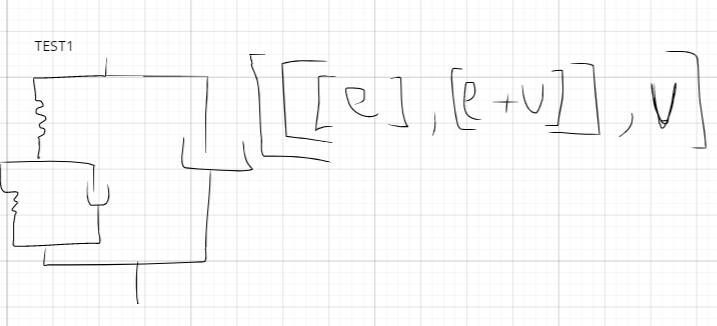

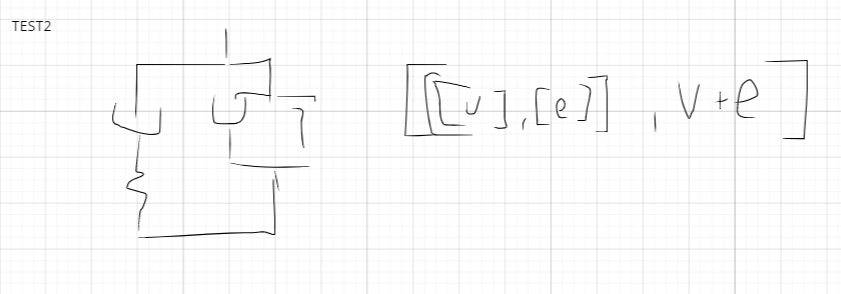

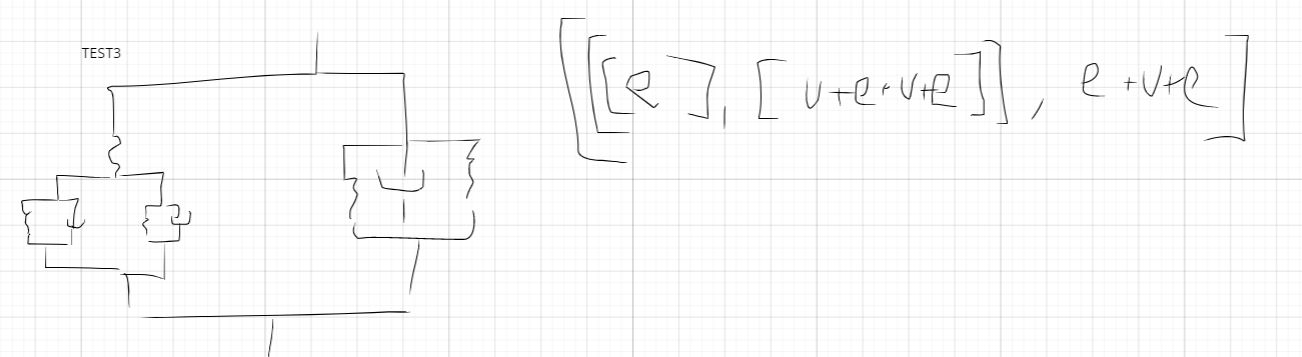

In [1]:
from sympy import *
import re

# заполнение массива данных осуществ-я данным образом
# Если последовательно соединять элементы, то нужно залить в одномерный массив
# Если параллельно, то также в одномерный массив, но через запятую

# пример test1: пускай есть система их 2-х малых подсистем
# Первая подсистема состоит из двух последовательно соед элементов e (elastic) и v (viscous) [[e], [v]]
# Вторая подсистема состоит из двух параллельно соед элементов [e,v]
# и все это соединено параллельно [[e],[v]], [e,v]
test1 = [
    [["e"], ["v"]], ["e","v"]
]

test2 = [
    [["e"], [["e", "v", "e"]]], "v"
]

test3 = [
    [["e"], [[["e","v"], ["e","v"]]]],["e","v","e"]
]
test4 = [
    [["e"],["v"]],[["e"],["v"]]
]


def changeX(string):
  # данная ф-я служит только для того, чтобы
  # заменить все иксы для дальнейшего использования
  # за счет того, что параллельное соедин элементов
  # дает нам право x=x1=x2=...xn

  e = string.split("x") 
  x = "x"
  for el in e:
    if(el[0] == "_"):
      
      x += el.split("(t)")[0]
      break
  return re.sub(r'x_\d+', x, string)


### Здесь все идеально, не трогать
def parallelStress(elements):
  # параллельное соединение элементов

  # идея точно такая же как и в функции splitArr, но только если достигаем одномерного массива
  # например [e,v,e] -> то вместо этого массива сюда перепишутся s=e+v+e 
  if(type(elements) != str):
    for i in range(len(elements)):
      if(type(elements[i]) != str):
        if (len(elements[i]) >= 1):
          if(len(elements[i]) == 1 and type(elements[i][0]) == str):
            pass
          else:
            # достигли того самого массива, который нам нужен
            # и тогда начинаем вычисление sigma параллельно соед элементов
            summ = ""
            for el in elements[i]:
              
              if(type(el) != str):
                # данное условие нужно, если так случилось, что массив выглядит след образом
                # [e,v, [[e],[v]]]
                # и тогда пока откладываем вычисление напряжения, так как приоритетнее вычисление последовательно соед элементов
                summ = ""
                break
              summ += "{el}+".format(el=el.split("=")[1])

            if(summ != ""):
              elements[i] = "{el}=".format(el=el.split("=")[0])+summ[:-1]
              elements[i] = changeX(elements[i]) # замена всех иксов на один и тот же, чтобы индексы были равны
            parallelStress(elements[i]) # ну и вызываем рекурсию, чтобы дальше искал другие вложенные, паралелльно соедиенные, элементы
    return elements
def splitArr(arr, depth="0"):
  for i in range(len(arr)):
    if(type(arr[i]) == list):
      # если так получилось, что элемент массива arr[i] является также массивом, 
      # то глубина увеличивается и для него же arr[i] перезапускаем данную функцию, устраивая рекурсию 
      depth += str(i)
      splitArr(arr[i], depth)
    elif (type(arr[i]) == str):
      # рано или поздно дойдем до самих элементов, то мы будем заполнять их сразу определяющими соотношениями
      if(arr[i] == "e"):
        arr[i] = "sigma_{depth}(t)=E_{depth}_{i}*x_{depth}(t)".format(depth=depth,i=i)
      elif(arr[i] == "v"):
        arr[i] = "sigma_{depth}(t)=eta_{depth}_{i}*diff(x_{depth}(t),t)".format(depth=depth,i=i)
  return arr
elem = splitArr(test1) # разделение массива и заполнение элементов, для первичного запуска добавим понятия глубины depth=0
print(elem)
print("/////////")
elem = parallelStress(parallelStress(elem))
print(elem)
print("/////////")
# elem = serialStress(elem)


[[['sigma_000(t)=E_000_0*x_000(t)'], ['sigma_0001(t)=eta_0001_0*diff(x_0001(t),t)']], ['sigma_001(t)=E_001_0*x_001(t)', 'sigma_001(t)=eta_001_1*diff(x_001(t),t)']]
/////////
[[['sigma_000(t)=E_000_0*x_000(t)'], ['sigma_0001(t)=eta_0001_0*diff(x_0001(t),t)']], 'sigma_001(t)=E_001_0*x_001(t)+eta_001_1*diff(x_001(t),t)']
/////////


In [2]:
from numpy.lib.shape_base import split
init_printing()
def serialStress(elements:list, src):
  xvar = ""
  isOk = False # показатель того, что достигли идеального массива для вычисления послед соед элементов
  # тут такая же идея с рекурсией, вот только не придумал еще способ, как можно оптимизировать код

  for el in elements:
    
    if(type(el) == list and len(el) == 1):
      isOk = True
      # эмпирическим путем заметили, что данное условие будет верным
      # во первых,  изначально назначили правилу соединения элементов
      # во вторых после вычисления парал-х элементов, получается у нас один элемент, который будет просто строкой
      # то есть [[e], [e+v]]
      s2 = el[0].split("=")[1] # берется правая часть определяющ соотношения, так как левая часть это просто напряжение
      # а так же, пока будем полагать, что у нас в левой части будет только sigma
      # а в правой части функция f(x,dx/dt,t)
      if("+" in s2):
        s2 = s2.split("+")[0].split("*")[1] # получаем деформации из ОС (опр-е соотношение), если вдруг здесь сумма элементов(т.е параллельно)
      else:
        s2 = s2.split("*")[1] # если вдруг там только один элемент, то есть s=E*x -> то получаем x
      if("diff" in s2):
        s2 = s2.split("diff(")[1].split(",")[0] # если вдруг там только один элемент, а также есть производная s=n*dx/dt, то получаем x
      xvar += s2 + "+" # ну и устанавливаем правило, что x=x1+x2+...+xn
    else:
      if(type(el) == list):
        # все плохие случаи и нужно еще углублиться в массив и на них перезапускаем функцию
        serialStress(el, src)

  # наконец достигли и нашли идеальный массив, то начинаем собственно работу
  if(isOk):
    changeEl = elements
    allx = xvar[:-1].split("+") # массив состоящий только из иксов [x1,x2,x3...]
    print("allx",allx)
    temp = allx[0]
    # то что ниже закомментировано, пока не знаю, зачем это делал, но кажется это нахождение x с минимальным индексом глубины

    # for i in range(len(allx)-1):
    #   if(len(allx[i]) > len(allx[i+1])):
    #     temp = allx[i+1]
    #   else:
    #     temp = allx[i]
    firststr = xvar[:-1].split("+")[0] # получили первый икс
    for el in range(len(elements)-1):
      if(len(elements[el][0].split("=")[0]) > len(elements[el+1][0].split("=")[0])):
        temp1 = elements[el+1][0].split("=")[0]
      else:
        temp1 = elements[el][0].split("=")[0]
    temp1 = temp1.split("(")[0][:-1]
    for el in elements:
      el[0] = el[0].replace(el[0].split("=")[0], temp1+"(t)")
    print("Рассмотрим ",elements) # собственно рассматриваем подсистему элементов, которую будем решать
    
    xvar = Eq(parse_expr(temp.split("(")[0][:-1] + "(t)"), parse_expr(xvar[:-1]))
    xvar # уравнение иксов x=x1+x2+x3...
    first = solve(xvar, parse_expr(firststr))[0] # выразили для x1 из x=x1+x2+...
    print( "xvar",xvar)
    aaa = str(elements[0]).replace(firststr, "({expr})".format(expr = str(first))) # заменили первый x1 в первом уравнении на x-x2-x3...
    print("aa",aaa)
    for xs in range(1, len(allx)):
      print(allx[xs])
      try:
        # если вдруг тут у нас диффур, то решаем диффур относительно x2 x3 x4...
        xx = dsolve(Eq(parse_expr(elements[xs][0].split("=")[0]), parse_expr(elements[xs][0].split("=")[1])), parse_expr(allx[xs])).rhs
      except ValueError:
        # иначе просто решаем уравнение относительно x2 x3 x4...
        xx = solve(parse_expr(elements[xs][0]), parse_expr(allx[xs]))[0]
      # полученное решение подставляем в первое уравнение
      aaa = aaa.replace(allx[xs], "({xx})".format(xx = str(xx)))
      print(aaa)
      print("Here")
      # print(allx[xs], str(xx))
    elements = aaa
    print("/////////////")
    print(elements) # Итого получили новое опред соотношение
    print("/////////////")
    print("src", src)

    # дальше можно не рассматривать, так как пытался решить проблему с интегралами

    # splitted = list(map(lambda x: sympify(x), elements[2:-2].split("=")))
    # elements = Eq(splitted[0], splitted[1])
    
    # elements = solve(elements, xvar.lhs)
    print(elements)
    # if("Integral" in elements):
    #   print("Найден интеграл")
    #   splitted = list(map(lambda x: sympify(x), elements[2:-2].split("=")))
    #   elements = Eq(diff(splitted[0],"t"), diff(splitted[1],"t"))
    #   elements = dsolve(elements, Function("sigma_00")("t"))

    #   if("Integral" in str(elements)):
    #     print("Найден еще интеграл")
    #     pprint(expand(Eq(diff(elements.lhs,"t"), 0)))
    #     pprint(solve(expand(Eq(diff(elements.lhs,"t"), 0)), Function("sigma_00")("t")))

    # if("Integral" in elements):
      
    #   print(elements)
    #   splitted = list(map(lambda x: sympify(x), elements[2:-2].split("=")))
    #   print(splitted[0])
    #   elements = Eq(diff(splitted[0], "t"), diff(splitted[1], "t"))
    #   ar = dsolve(elements, Function(str(splitted[0]).split("(")[0])("t"))
    #   pprint(ar, use_unicode=True)
    #   ar1 = solve(Eq(diff(ar.lhs, "t"), diff(ar.rhs, "t")), Function(str(splitted[0]).split("(")[0])("t"))
    #   pprint(ar1,use_unicode=True)
    
print("res", serialStress(elem, elem))


allx ['x_000(t)', 'x_0001(t)']
Рассмотрим  [['sigma_00(t)=E_000_0*x_000(t)'], ['sigma_00(t)=eta_0001_0*diff(x_0001(t),t)']]
xvar Eq(x_00(t), x_000(t) + x_0001(t))
aa ['sigma_00(t)=E_000_0*(x_00(t) - x_0001(t))']
x_0001(t)
['sigma_00(t)=E_000_0*(x_00(t) - (C1 + Integral(sigma_00(t), t)/eta_0001_0))']
Here
/////////////
['sigma_00(t)=E_000_0*(x_00(t) - (C1 + Integral(sigma_00(t), t)/eta_0001_0))']
/////////////
src [[['sigma_00(t)=E_000_0*x_000(t)'], ['sigma_00(t)=eta_0001_0*diff(x_0001(t),t)']], 'sigma_001(t)=E_001_0*x_001(t)+eta_001_1*diff(x_001(t),t)']
['sigma_00(t)=E_000_0*(x_00(t) - (C1 + Integral(sigma_00(t), t)/eta_0001_0))']
res None


 _____________________________________________________________________________
 
Дальше тут идет чисто черновик, а внизу ждет первая версия калькулятора, без учета вложенных подсистем


In [25]:
eq = parse_expr("E_000_0*(x_00(t) - (C1 + Integral(sigma_00(t), t)/eta_0001_0))")

deq = dsolve(Eq(eq, sympify("sigma_00(t)")), Function("sigma_00")("t"))
deq

# deq = dsolve(Eq(diff(eq,"t"), diff(sympify("sigma_00(t)"),"t")), Function("sigma_00")("t"))
eeq = Eq(diff(eq,"t"), diff(sympify("sigma_00(t)"),"t"))
dsolve(eeq, Function("sigma_00")("t"))

eq = parse_expr("E_001_0*x_001(t)+eta_001_1*diff(x_001(t),t)")
deq = dsolve(Eq(eq, sympify("sigma_001(t)")), Function("x_001")("t"))
solve(Eq(diff(deq.lhs, "t"),0), Function("x_001")("t"))
Eq(diff(deq.lhs, "t"),0)
t,s = symbols("t,s")
eq = expand(Eq(laplace_transform(diff(deq.lhs, ("t")), t,s),laplace_transform(diff(deq.rhs, "t"), t,s)))
# solve(eq, laplace_transform(diff(deq.lhs, ("t")), t,s))
ls = solve(eq, laplace_transform(Function("sigma_00")("t"), t,s))
ls

[]

In [ ]:
ls

In [ ]:
inverse_laplace_transform(ls, s,t)

                                      ⎛s⋅LaplaceTransform(x₀₀(t), t, s)       
E₀₀₀ ₀⋅η₀₀₀₁ ₀⋅InverseLaplaceTransform⎜────────────────────────────────, s, t,
                                      ⎝       E₀₀₀ ₀ + η₀₀₀₁ ₀⋅s              

     ⎞
 None⎟
     ⎠

In [ ]:
elem = ['sigma_00(t)=E_000_0*(x_00(t) - (C1 + Integral(sigma_00(t), t)/eta_0001_0))', "sigma_001(t)=E_001_0*x_001(t)+eta_001_1*diff(x_001(t),t)"]
def hardPar(elem):
  allx = []
  for i in elem:
    allx.append(re.search(r'x_\d+', i).group(0))
  print(allx)
  min = allx[0]
  sum = ""
  for i in allx:
    sum += i + "(t)+"
    if(i == min):
      pass
    elif(i < min):
      min = i
  x = min[:-1]+"(t)="+sum[:-1]
  print(x)

# hardPar(elem)


['x_00', 'x_001']
x_0(t)=x_00(t)+x_001(t)


In [ ]:
import re
e = "sigma_0001001(t)=E_000100_0*x_000100(t)+eta_000100_1*diff(x_000100(t),t)+E_0001001_0*x_0001001(t)+eta_0001001_1*diff(x_0001001(t),t)"
# solve(Eq(sympify(e.split("=")[0].split("(")[0]), sympify(e.split("=")[1])), Function("x_000100")("t"))
def changeX(string):
  e = string.split("x")
  x = "x"
  for el in e:
    if(el[0] == "_"):
      
      x += el.split("(t)")[0]
      break
  print(x)
  return re.sub(r'x_\d+', x, string)

changeX(e)


x_000100


'sigma_0001001(t)=E_000100_0*x_000100(t)+eta_000100_1*diff(x_000100(t),t)+E_0001001_0*x_000100(t)+eta_0001001_1*diff(x_000100(t),t)'

In [ ]:
import re

s = "E*x1+n*x2+"
new_s = re.sub(r"x[0-9]*\+", "x+", s)

print(new_s)


E*x+n*x+


In [ ]:
from sympy import *
elements = [["e", "v"],["v"]]
def setElem(elem):
  for i in range(len(elem)):
    for j in range(len(elem[i])):
      if(elem[i][j] == "e"):
        temp = input("Введите упругий коэффициент [E_{i}{j}]:".format(i = i,j = j))
        elem[i][j] = temp + "*x_{i}(t)".format(i = i)
      elif(elem[i][j] == "v"):
        #initCond["[nu_{i}{j}]:".format(i = i,j = j)] = input("Введите НУ при t = 0 для [nu_{i}{j}]:".format(i = i,j = j))
        temp = input("Введите вязкий коэффициент [\eta_{i}{j}]:".format(i = i,j = j))
        # initCond.append(float(input("Введите НУ при t=0 для [eta_{i}[j]]".format(i=i,j=j))))
        elem[i][j] =  temp + "*diff(x_{i}(t),t)".format(i = i)

  return elem
# НУ для sigma достаточно только один раз задать
# а для x(t) необходимо каждому элементу

x = Function("x")("t")
settedElem = setElem(elements)

settedElem



KeyboardInterrupt: ignored

In [ ]:
def parallelStress(elem):
  stress = []
  summ = ""
  
  for i in elem:
    for j in i:
      summ += j + "+"
    stress.append(summ[:-1])
    summ = ""

  return stress
elements = parallelStress(settedElem)
elements

In [ ]:
def serialStress(elem):
  x_0 = "x(t)"
  for i in range(1,len(elem)):
    x_0 += "-x_{i}(t)".format(i=i)
  elem[0] = elem[0].replace("x_0(t)", "({x_0})".format(x_0=x_0))
  symSigmas = []
  for i in elem:
    symSigmas.append(parse_expr(i))

  # print(symSigmas)
  j = 0

  for i in range(1,len(elem)):
    try:
      x_i = Function("x_{i}".format(i=i))("t")
      deq = dsolve(Eq(symSigmas[i],Function("sigma")("t"))).rhs
      j += 1
    except ValueError:
      # print("debug")
      deq = solve(Eq(symSigmas[i],Function("sigma")("t")), Function("x_{i}".format(i=i))("t"))[0]
      # print(deq)
    symSigmas[0] = symSigmas[0].subs(Function("x_{i}".format(i=i))("t"), deq)
  return symSigmas
elem = serialStress(elements)
deq = Eq(Function("sigma")("t"),elem[0])
deq = deq.subs(Symbol("eta1"), Symbol("eta1", complex=False))
eeqq = Eq(diff(deq.lhs, "t"), diff(deq.rhs, "t"))
solve(Eq(diff(dsolve(eeqq, Function("sigma")("t")).lhs,"t"), diff(dsolve(eeqq, Function("sigma")("t")).rhs, "t")), Function("sigma")("t"))[0]

In [ ]:
t,s=symbols("t, p")
right = laplace_transform(deq.rhs, t,s)[0]
left = laplace_transform(deq.lhs, t,s)
right = right.subs(Symbol("mu1"), Symbol("mu1", complex=False))

In [ ]:
mu1 = expand(Symbol("mu1", complex=False),complex=False)


In [ ]:
a = parse_expr("mu")
a.is_real()


In [ ]:
ee = solve(Eq(left, right), laplace_transform(Function("x")("t"),t,s), complex=False)[0]
ee = ee.subs(Symbol("mu1"), mu1)

In [ ]:
ee1=inverse_laplace_transform(ee, s, t)
ee1.subs("im(eta_1)", 0)


In [ ]:
deq
xx = parse_expr(input("Enter an expr x(t) = "))
deq1 = deq.subs(Function("x")("t"), xx)
sigmaa = dsolve(deq1, Function("sigma")("t"), ics={Function("sigma")(0):1})
sigmas = []
xs = []
import numpy as np
T = np.arange(0,1,0.01)
for t in T:
  sigmas.append(float(sigmaa.rhs.subs("t", t)))
  xs.append(float(xx.subs("t", t)))
from matplotlib import pyplot as plt
sigmaa

In [ ]:
plt.plot(T,xs)
plt.plot(T,sigmas)
plt.figure()
plt.plot(xs, sigmas)

In [ ]:
# x = parse_expr(input("Enter an expr x(t) = "))
sigma = parse_expr(input("Enter an expr sigma(t) = "))
sigma
deq1 = deq.subs(Function("sigma")("t"), sigma)
x = deq1
print(x)
dx = Eq(diff(Function("x")("t"),"t"), solve(x, diff(Function("x")("t"),"t"))[0])
# dsolve(deq, Function("x")("t"), ics={Function("x")(0):0,Function("x")(1):1})
x = dsolve(dx, ics = {Function("x")(0):1})

sigmas = []
xs = []
import numpy as np
T = np.arange(0,1,0.01)
for t in T:
  sigmas.append(float(sigma.subs("t", t)))
  xs.append(float(x.rhs.subs("t", t)))
from matplotlib import pyplot as plt

x

In [ ]:
t_a = 0
t_b = 1
t_arr = []
n = 20
sigma_arr = []
for i in range(n):
  t_arr.append((t_b-t_a)/(n-1)*i)
  sigma_arr.append(sigma.subs("t", t_arr[i]))

x0 = 1
def Euler(x ,x0, t):
  xa = [x0]
  for i in range(1,len(t)):
    xa.append(xa[i-1] + (t[1]-t[0])*x.subs({"t":t[i-1], "x":xa[i-1]}))
  return xa
# Euler(, x0, t_arr)
de = solve(x,diff(Function("x")("t")))[0]
print(de)
xa = Euler(de, x0,t_arr)
x = dsolve(x, ics={Function("x")(0):1})
xx = []
for i in t_arr:
  xx.append(x.rhs.subs("t", i))

In [ ]:
print(xa)
print(xx)
plt.figure()
plt.plot(t_arr,xx)
plt.plot(t_arr,xa)


In [ ]:
from sympy import init_session
init_session() 
latex(Integral(1/x))
